In [118]:
import pandas as pd
import copy
from sklearn import preprocessing



In [65]:
data_path = "/mnt/sda/abka03-data/tabular/creditcard.csv"

In [262]:
# Scale the dat
from sklearn import preprocessing
import pandas as pd

# Load the tabular data into a pandas DataFrame
data = pd.read_csv(data_path)
data = data.drop("Time", axis=1)
# Extract the numerical columns that need normalization
num_cols = data.select_dtypes(include=[float]).columns.tolist()


# Initialize a MinMaxScaler object to perform normalization
scaler = preprocessing.MinMaxScaler()

# Fit the scaler on the numerical data
scaler.fit(data[num_cols])

# Transform the numerical data using the scaler
data[num_cols] = scaler.transform(data[num_cols])


In [263]:
#credit_card_data = pd.read_csv(data_path)
# Load the tabular data into a pandas DataFrame

# Extract the numerical columns that need normalization

# Shuffle the data
credit_card_data = data.sample(frac=1).reset_index(drop=True)
print(credit_card_data.head())
print(f"Total number of data: {len(credit_card_data)}")
print(f"Total number of features: {credit_card_data.shape[1] -1}")
# Split the dataset into training test and validation set
train_size = int(0.6 * len(credit_card_data))
val_size = int(0.2 * len(credit_card_data))

# Split the data into train, validation, and test sets
train_data = credit_card_data.loc[:train_size]
val_data = credit_card_data.loc[train_size:train_size+val_size]
test_data = credit_card_data.loc[train_size+val_size:]

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Validation data size: {len(val_data)}")

# Drop the time from the train data
#train_data = train_data.drop("Time", axis=1)
#test_data = test_data.drop("Time", axis=1)
#val_data = val_data.drop("Time", axis=1)
print(f"Fetures name in the data: {','.join(list(train_data.columns))}")



         V1        V2        V3        V4        V5        V6        V7  \
0  0.976322  0.767319  0.850990  0.311263  0.762616  0.264534  0.263765   
1  0.958601  0.733538  0.804513  0.343065  0.759797  0.264888  0.272922   
2  0.974030  0.767509  0.836418  0.314862  0.764396  0.253305  0.269284   
3  0.956106  0.727384  0.816184  0.222135  0.753654  0.260515  0.268382   
4  0.995141  0.749913  0.824406  0.179431  0.756354  0.261842  0.256615   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.788012  0.472322  0.509301  ...  0.558600  0.490594  0.666679  0.408058   
1  0.781364  0.477063  0.502258  ...  0.572271  0.501434  0.654863  0.480484   
2  0.782594  0.451105  0.508815  ...  0.563793  0.517828  0.662995  0.464377   
3  0.779979  0.397560  0.528787  ...  0.565941  0.477886  0.650945  0.329075   
4  0.786358  0.422571  0.544315  ...  0.560174  0.515199  0.669525  0.471044   

        V25       V26       V27       V28    Amount  Class  
0  0.59

In [264]:
class_identifier = train_data.loc[train_data['Class'] == 0]
print(class_identifier.head())

         V1        V2        V3        V4        V5        V6        V7  \
0  0.976322  0.767319  0.850990  0.311263  0.762616  0.264534  0.263765   
1  0.958601  0.733538  0.804513  0.343065  0.759797  0.264888  0.272922   
2  0.974030  0.767509  0.836418  0.314862  0.764396  0.253305  0.269284   
3  0.956106  0.727384  0.816184  0.222135  0.753654  0.260515  0.268382   
4  0.995141  0.749913  0.824406  0.179431  0.756354  0.261842  0.256615   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.788012  0.472322  0.509301  ...  0.558600  0.490594  0.666679  0.408058   
1  0.781364  0.477063  0.502258  ...  0.572271  0.501434  0.654863  0.480484   
2  0.782594  0.451105  0.508815  ...  0.563793  0.517828  0.662995  0.464377   
3  0.779979  0.397560  0.528787  ...  0.565941  0.477886  0.650945  0.329075   
4  0.786358  0.422571  0.544315  ...  0.560174  0.515199  0.669525  0.471044   

        V25       V26       V27       V28    Amount  Class  
0  0.59

In [274]:
# Create pytorch data generator for tabular dat
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import random
class PandasDataset(Dataset):

    def __init__(self, dataframe, supervised=False, train=False):
        self.data = dataframe.values
        self.supervised = supervised
        self.train = train
    def __len__(self):
        return len(self.data)

    def random_dropout(self, data, dropout_prob):
        mask = torch.tensor(np.random.binomial(n=1, p=1-dropout_prob, size=data.shape))
        masked_data = data * mask.float()
        return masked_data
    def pow_augment(self, data,  p):
        masked_data = torch.pow(data, p)
        return masked_data

    def __getitem__(self, index):
        #x = (torch.from_numpy(self.data[index, :-1]).float() - np.min(self.data[index, :-1]) )/ (np.max(self.data[index, :-1]) - np.min(self.data[index, :-1]))
        x = torch.from_numpy(self.data[index, :-1]).float()
        if self.train:
            x = self.random_dropout(x, 0.5)
            random_number = round(random.uniform(0.9, 1), 2)
            x = self.pow_augment(x, random_number)
        if self.supervised:
            y = torch.tensor(self.data[index, -1]).float()
        else:
            y = -1
        return x, y


In [275]:
from torch.utils.data import DataLoader
import numpy as np
# Assuming you have a Pandas DataFrame called 'data'
dataset = PandasDataset(train_data, supervised=True, train=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# print 5 samples of data
print(len(dataloader.dataset))
for batch_idx, (data, target) in enumerate(dataloader):
    print(data, target)
    if batch_idx > 4:
        break




170885
tensor([[9.9118e-01, 7.8857e-01, 8.4149e-01, 4.5792e-01, 0.0000e+00, 2.9687e-01,
         2.9448e-01, 8.0071e-01, 5.0837e-01, 5.6090e-01, 0.0000e+00, 0.0000e+00,
         5.5702e-01, 7.2309e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0204e-01,
         5.0379e-01, 0.0000e+00, 5.8726e-01, 5.4890e-01, 0.0000e+00, 0.0000e+00,
         6.0958e-01, 4.6525e-01, 4.4564e-01, 3.4215e-01, 5.6532e-04]]) tensor([0.])
tensor([[0.9722, 0.0000, 0.8637, 0.0000, 0.7551, 0.0000, 0.0000, 0.7920, 0.0000,
         0.5478, 0.0000, 0.0000, 0.5005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4223, 0.0000,
         0.0000, 0.0000]]) tensor([0.])
tensor([[0.9829, 0.0000, 0.0000, 0.2067, 0.0000, 0.2621, 0.2709, 0.7881, 0.0000,
         0.5473, 0.0000, 0.7009, 0.0000, 0.6400, 0.3889, 0.0000, 0.7536, 0.6323,
         0.5504, 0.0000, 0.0000, 0.0000, 0.0000, 0.4845, 0.5924, 0.3538, 0.4282,
         0.3250, 0.0000]]) tensor([0.])
tensor([[0.9472, 0.

In [276]:
import torch.nn as nn
class AutoEncoder(nn.Module) :
    def __init__(self, rep_dim=10, input_shape=30, dim = 128):
        super().__init__()
        self.relu = nn.ReLU()
        
        ## Encoder
        self.rep_dim = rep_dim
        self.fc1 = nn.Linear(input_shape, dim,  bias=False)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(dim, eps=1e-04, affine=False)
        self.fc2 = nn.Linear(dim, self.rep_dim, bias=False)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.m = nn.Softmax(dim=1)

        ## Decoder
        self.fc3 = nn.Linear(self.rep_dim, dim,  bias=False)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.bn2 = nn.BatchNorm1d(dim, eps=1e-04, affine=False)
        self.fc4 = nn.Linear(dim,  input_shape,  bias=False)
        nn.init.xavier_uniform_(self.fc4.weight)
        
    def forward(self, x):
        encode = self.fc2(self.relu(self.fc1(x)))
        encode = self.m(encode)
        # create a sample Torch array
        arr = torch.sum(encode, dim=1)


        # check if any value in the array is less than 1
        if torch.min(arr) < .99 :

            # if yes, raise an exception
            raise ValueError("Array contains a value less than 1")
        if torch.max(arr) >  1.10 :

            # if yes, raise an exception
            raise ValueError("Array contains a value greater than 1")


        decode = self.fc4(self.relu(self.fc3(encode)))
        return encode, decode

In [284]:
num_epochs = 20
log_interval = 1000
lam = 1

In [285]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have a PyTorch dataset and model defined

# Set device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = AutoEncoder(rep_dim=2, input_shape=29)
model.to(device)

# Define loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Instantiate data loader
dataset = PandasDataset(train_data, supervised=True, train=True)
train_loader = DataLoader(dataset=dataset, batch_size=10000, shuffle=True)
val_dataset = PandasDataset(val_data, supervised=True)
val_loader = DataLoader(dataset=val_dataset , batch_size=1000, shuffle=False)

# Training loop
best_acc = 0.0
for epoch in range(num_epochs):
    # Set model to train mode
    model.train()

    # Iterate over batches
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Load data to device
        data = data.to(device)
        targets = targets.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(data)
        outputs = predictions[1]
        pred_probs = predictions[0]


        # Calculate loss
        l1 = criterion(outputs, data) 
        l2 = 0.0
        #print(pred_probs)
        #print(torch.max(pred_probs))
        for it in [(-pred_prob * torch.log2(pred_prob)).sum() for pred_prob in pred_probs]:
            l2 += it
        loss = lam * l1 + (1.0-lam) * l2
        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step() # Print progress
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # Evaluate on validation set after each epoch (optional)
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        class_sample = class_identifier.sample(n=5000)
        identifiers_sample = PandasDataset(class_sample, supervised=True)
        identifiers_loader = DataLoader(dataset=identifiers_sample, batch_size=5000, shuffle=True)
        id_samples = next(iter(identifiers_loader))
        org_nonanomaly_class = id_samples[1]
        org_bins = torch.bincount(org_nonanomaly_class.int())
        org_nonanomaly_class  = torch.argmax(org_bins).item()
        nonanomaly_class = model(id_samples[0].to(device))[0]
        nonanomaly_class = nonanomaly_class.argmax(dim=1, keepdim=True).view(-1)
        bins = torch.bincount(nonanomaly_class)
        nonanomaly_class  = torch.argmax(bins).item()
        code = {nonanomaly_class: org_nonanomaly_class, org_nonanomaly_class: nonanomaly_class}


        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            out_pred = output[0]
            output = output[1]
            val_loss += criterion(output, data).item()
            pred = out_pred.argmax(dim=1, keepdim=True)
            if nonanomaly_class == org_nonanomaly_class: 
                output_tensor = pred
                
            else:
                output_tensor = torch.tensor([[code[x[0].item()]] for x in pred]).to(device)

            #print(out_pred.shape)
            #print(f"Prediction: {pred[0]} Target: {target[0]}")
            correct += output_tensor.eq(target.view_as(output_tensor)).sum().item()

        val_loss /= len(val_loader.dataset)
        accuracy = 100. * correct / len(val_loader.dataset)
        if accuracy > best_acc:
            best_acc = accuracy
            # save the state dictionary
            torch.save(model.state_dict(), 'model_weights.pth')



        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)'.format(
            val_loss, correct, len(val_loader.dataset), accuracy))


Train Epoch: 0 [0/170885 (0%)]	Loss: 0.177270

Validation set: Average loss: 0.0003, Accuracy: 56866/56962 (99.831467%)
Train Epoch: 1 [0/170885 (0%)]	Loss: 0.176417

Validation set: Average loss: 0.0003, Accuracy: 56866/56962 (99.831467%)
Train Epoch: 2 [0/170885 (0%)]	Loss: 0.175605

Validation set: Average loss: 0.0003, Accuracy: 56866/56962 (99.831467%)
Train Epoch: 3 [0/170885 (0%)]	Loss: 0.174491

Validation set: Average loss: 0.0003, Accuracy: 56866/56962 (99.831467%)
Train Epoch: 4 [0/170885 (0%)]	Loss: 0.173554

Validation set: Average loss: 0.0003, Accuracy: 56866/56962 (99.831467%)
Train Epoch: 5 [0/170885 (0%)]	Loss: 0.173514


KeyboardInterrupt: 

In [281]:
test_dataset = PandasDataset(test_data, supervised=True)
test_loader = DataLoader(dataset=test_dataset , batch_size=1000, shuffle=False)

In [282]:


# define your model
model = AutoEncoder(rep_dim=2, input_shape=29).to(device)

# load the state dictionary
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
val_loss = 0
correct = 0
predictions = []
with torch.no_grad():
    class_sample = class_identifier.sample(n=5000)
    identifiers_sample = PandasDataset(class_sample, supervised=True)
    identifiers_loader = DataLoader(dataset=identifiers_sample, batch_size=5000, shuffle=True)
    id_samples = next(iter(identifiers_loader))
    org_nonanomaly_class = id_samples[1]
    org_bins = torch.bincount(org_nonanomaly_class.int())
    org_nonanomaly_class  = torch.argmax(org_bins).item()
    nonanomaly_class = model(id_samples[0].to(device))[0]
    nonanomaly_class = nonanomaly_class.argmax(dim=1, keepdim=True).view(-1)
    bins = torch.bincount(nonanomaly_class)
    nonanomaly_class  = torch.argmax(bins).item()
    code = {nonanomaly_class: org_nonanomaly_class, org_nonanomaly_class: nonanomaly_class}
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        out_pred = output[0]
        output = output[1]
        predictions = predictions + out_pred.detach().cpu().tolist()
        val_loss += criterion(output, data).item()
        pred = out_pred.argmax(dim=1, keepdim=True)
        if nonanomaly_class == org_nonanomaly_class: 
            output_tensor = pred
            
        else:
            output_tensor = torch.tensor([[code[x[0].item()]] for x in pred]).to(device)

        #print(out_pred.shape)
        #print(f"Prediction: {pred[0]} Target: {target[0]}")
        correct += output_tensor.eq(target.view_as(output_tensor)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    print(accuracy)

    print(predictions[0])

99.79811102138268
[0.44797641038894653, 0.5520235896110535]


0.646


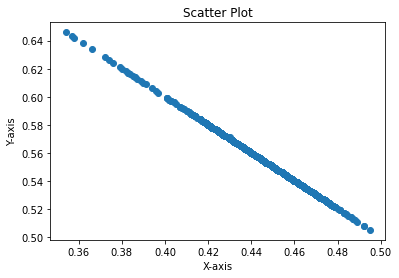

In [283]:
import matplotlib.pyplot as plt

# create 2D list
data = predictions


# create x and y lists from the 2D list
x = [round(row[0],3) for row in data]
y = [round(row[1],3) for row in data]
print(max(y))
# create scatter plot
plt.scatter(x, y)

# set title and axis labels
plt.title('Scatter Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# display the plot
plt.show()

